In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import os

In [78]:
data_dir='./Belgium Datasets'
train_dir=data_dir+'/BelgiumTSC_Training/Training'
test_dir=data_dir+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [79]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0


In [80]:
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0
5,./Belgium Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0.0,0


In [81]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0


In [82]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 35
resize_y  = 35
num_of_channels = 3
directory = ""
Epochs=25
train_length = len(df)

In [83]:
# Necessary Functions

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
def upSampleDataFrame(df,upSampleCount=300):
    starting_time = time.time()
    classes = {}

    for val in range(num_of_classes):
        classes[val]=[]

    max_repeating = 0

    for index,row in df.iterrows():
        classes[row.values[7]].append(row.values)

    # for key in classes:
    #     max_repeating = max(max_repeating,len(classes[key]))
    
    row = []
    random.seed(42)
    for i in range(num_of_classes):
        length = len(classes[i])
        want = upSampleCount - length
        for j in range(len(classes[i])):
            row.append(classes[i][j])
        if(want<=0):
            continue
        for j in range(want):
            select_image = random.randint(0,length-1)
            angle = random.randint(0,359)
            f = classes[i].copy()
            f[0][8] = angle
            row.append(f[0])
    np.random.seed(42)
    np.random.shuffle(row)

    df = pd.DataFrame(row,columns = df.columns)

    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Total number of images after Upsampling: ", len(df))
    print("\n\nTime taken to upsample images : ",total_time," min")
    return df

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[0]).crop((row[3],row[4],row[5],row[6])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[7])

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[0]).crop((row[3],row[4],row[5],row[6])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[7])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  4591


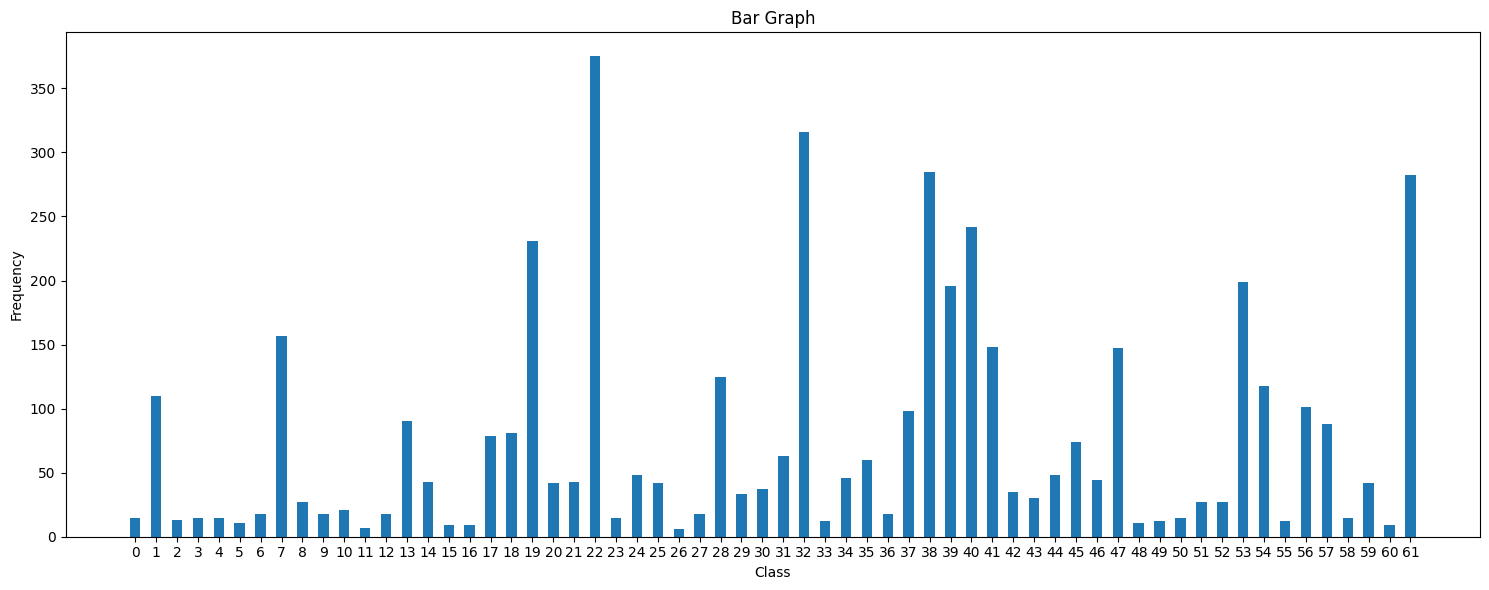

In [84]:
#Statistics of Data
viewStatistics(df)

In [85]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  4591


Total number of images after Upsampling:  31000


Time taken to upsample images :  0.005144202709197998  min
Total Training Examples :  31000


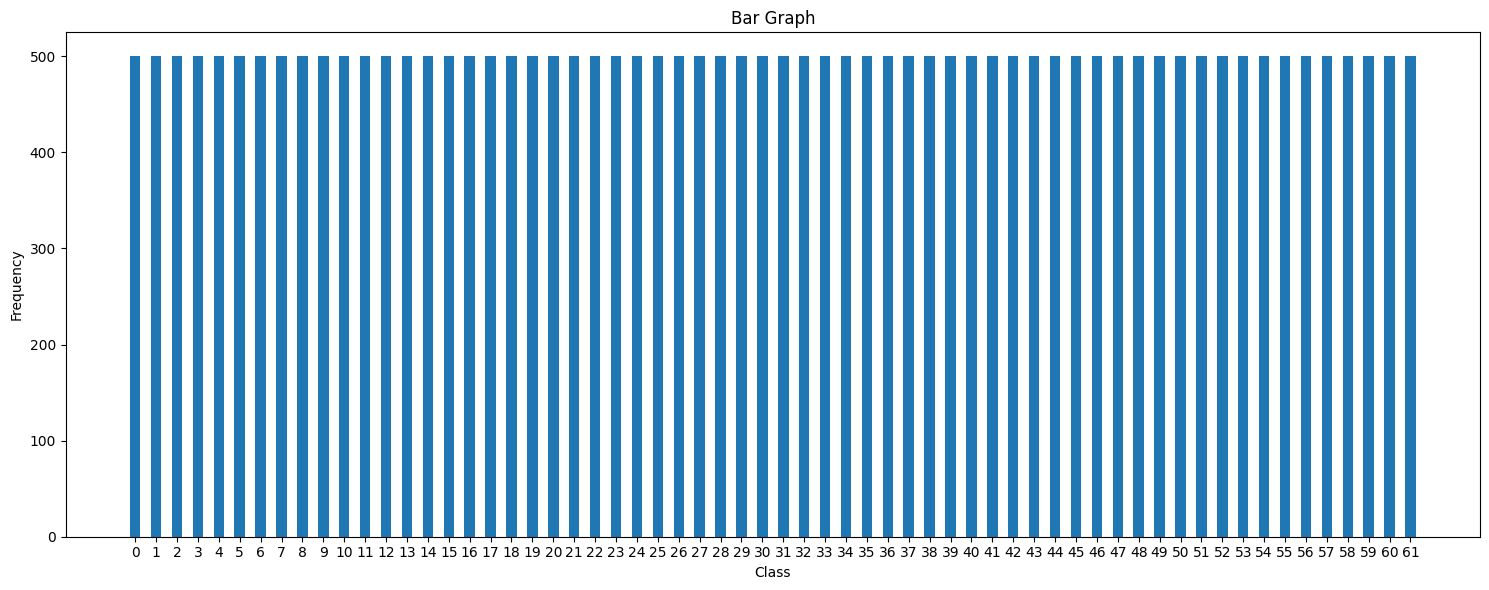

In [86]:
df = upSampleDataFrame(df,500)
viewStatistics(df)

In [87]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        img = img.rotate(val[8])
        ax = axes[row,col+1]
        ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [88]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def Do_Crop(self,path,x1,y1,x2,y2,r):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.rotate(r)
        img = img.resize((self.resize_x,self.resize_y))
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row.iloc[0],row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[6],row.iloc[8]))
        self.Y.append(int(row.iloc[7]))
    
    def Get_Data(self,length):
        self.X = []
        self.Y = []
        want = [0]*num_of_classes
        for i in range(len(df)):
            row = df.iloc[i]
            if(want[int(row.iloc[6])]<length):
                want[int(row.iloc[6])] = want[int(row.iloc[6])]+1
                self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(df)):
            row = df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

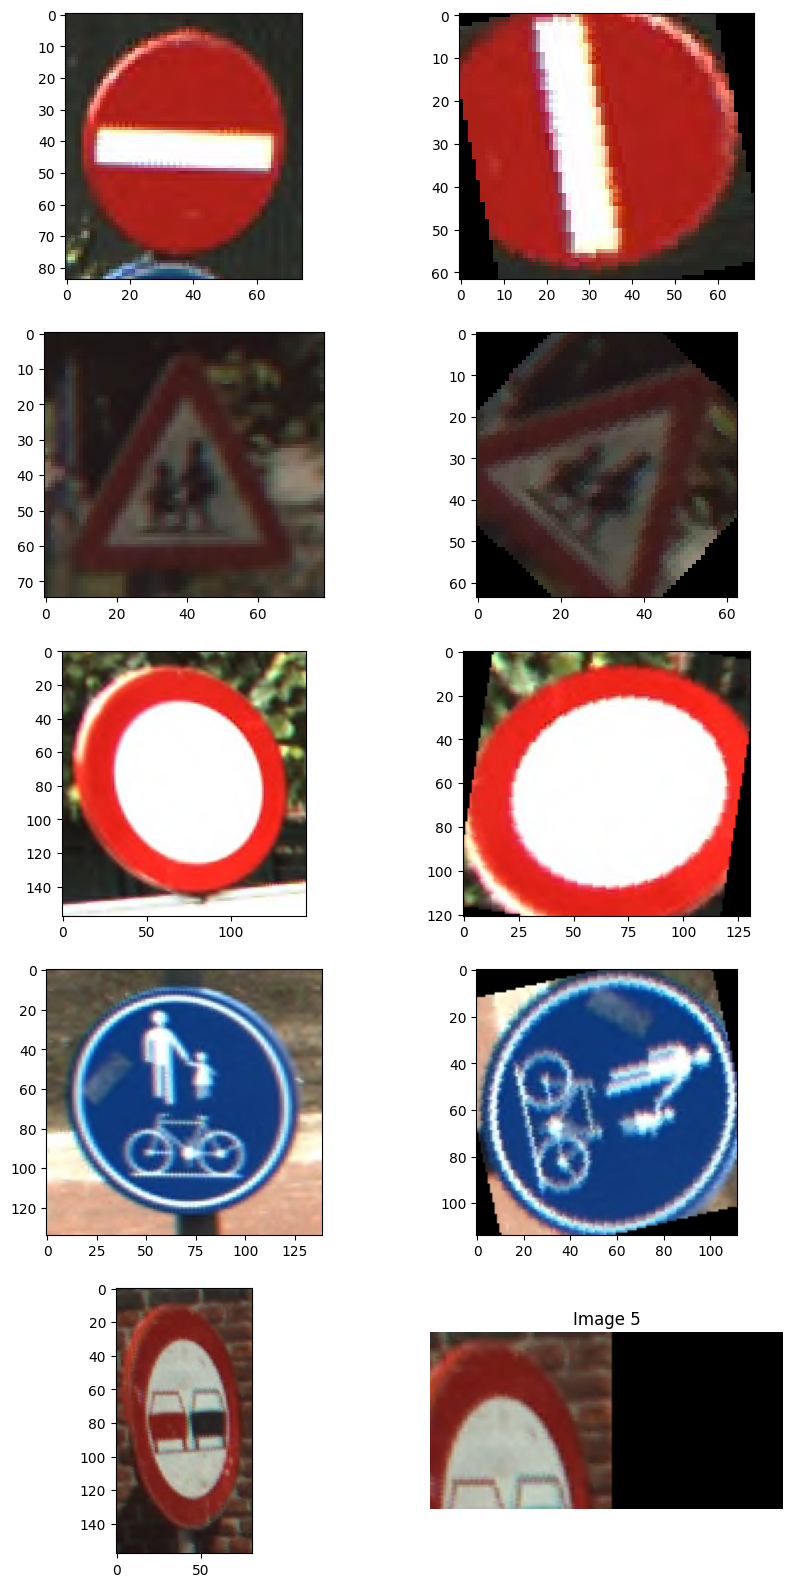

In [89]:
showExamples(df)

In [90]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  0.37499252557754514  min


In [91]:
X_train = data.X
Y_train = data.Y

In [92]:
#Data_Augmentation
X_train = X_train/255.0

In [93]:
# conversion of Y_train into 2d array in order to feed CNN 
Temp = []
for i in range(len(Y_train)):
    row = [0]*num_of_classes
    row[Y_train[i]]=1
    Temp.append(np.array(row))
Y_train = np.array(Temp)

In [105]:
# Implementation of CNN DeepLayered

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(resize_x, resize_y, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    
    Dense(num_of_classes, activation='softmax') 
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 35, 35, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 35, 35, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 35, 35, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 256)       295168    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 256)         0         
 g2D)                                                 

In [106]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [107]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.3)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/25
185/679 [=======>......................] - ETA: 2:51 - loss: 1.9042 - accuracy: 0.5382

KeyboardInterrupt: 

In [ ]:
#Saving the model
model.save("CNN_DeepLayerWeights_Belgium")

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [97]:
#Loading weights into CNN model 
model = tf.keras.models.load_model("CNN_DeepLayerWeights_Belgium")

In [108]:
df_test=[[]]
df_test=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df_test=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
0,./Belgium Datasets/BelgiumTSC_Training/Trainin...,181.0,141.0,15.0,12.0,165.0,128.0,50.0,0
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,248.0,266.0,21.0,22.0,227.0,244.0,25.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,59.0,62.0,5.0,5.0,53.0,57.0,2.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,199.0,206.0,17.0,17.0,181.0,189.0,15.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,240.0,111.0,20.0,9.0,219.0,101.0,48.0,0


In [109]:
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
0,./Belgium Datasets/BelgiumTSC_Training/Trainin...,181.0,141.0,15.0,12.0,165.0,128.0,50.0,0
1,./Belgium Datasets/BelgiumTSC_Training/Trainin...,248.0,266.0,21.0,22.0,227.0,244.0,25.0,0
2,./Belgium Datasets/BelgiumTSC_Training/Trainin...,59.0,62.0,5.0,5.0,53.0,57.0,2.0,0
3,./Belgium Datasets/BelgiumTSC_Training/Trainin...,199.0,206.0,17.0,17.0,181.0,189.0,15.0,0
4,./Belgium Datasets/BelgiumTSC_Training/Trainin...,240.0,111.0,20.0,9.0,219.0,101.0,48.0,0


Total Training Examples :  33534


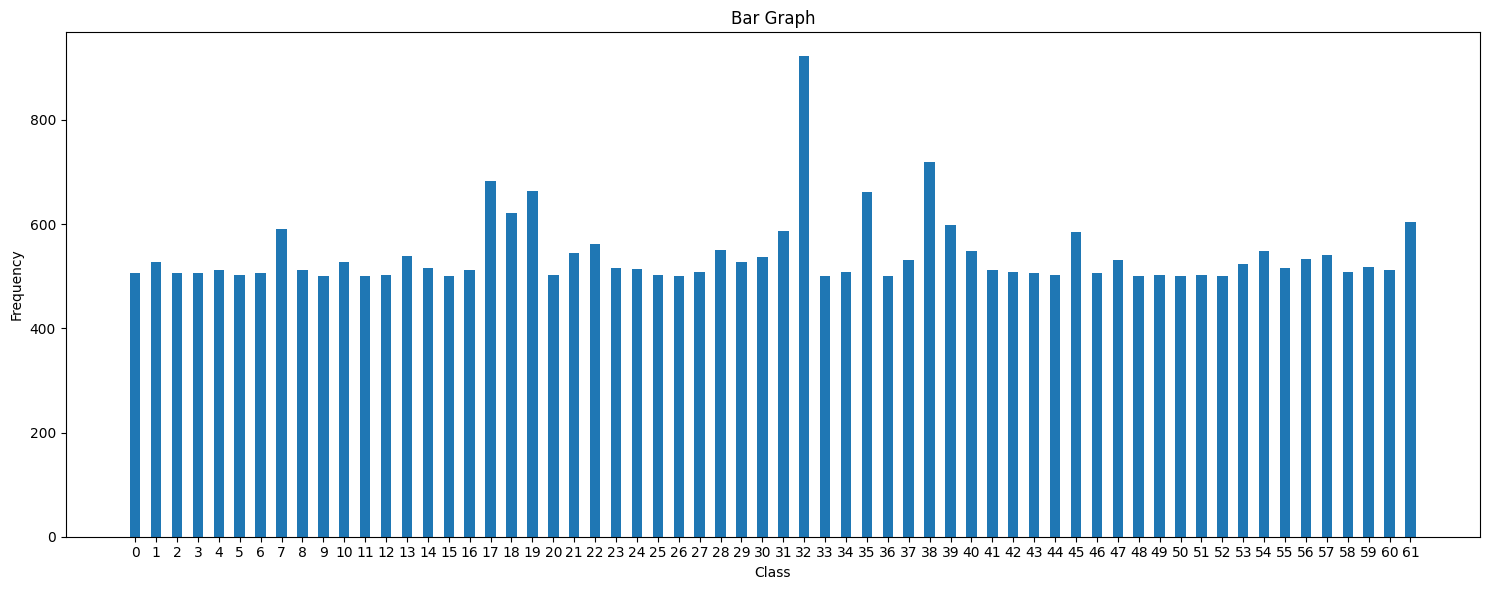

In [110]:
viewStatistics(df_test)

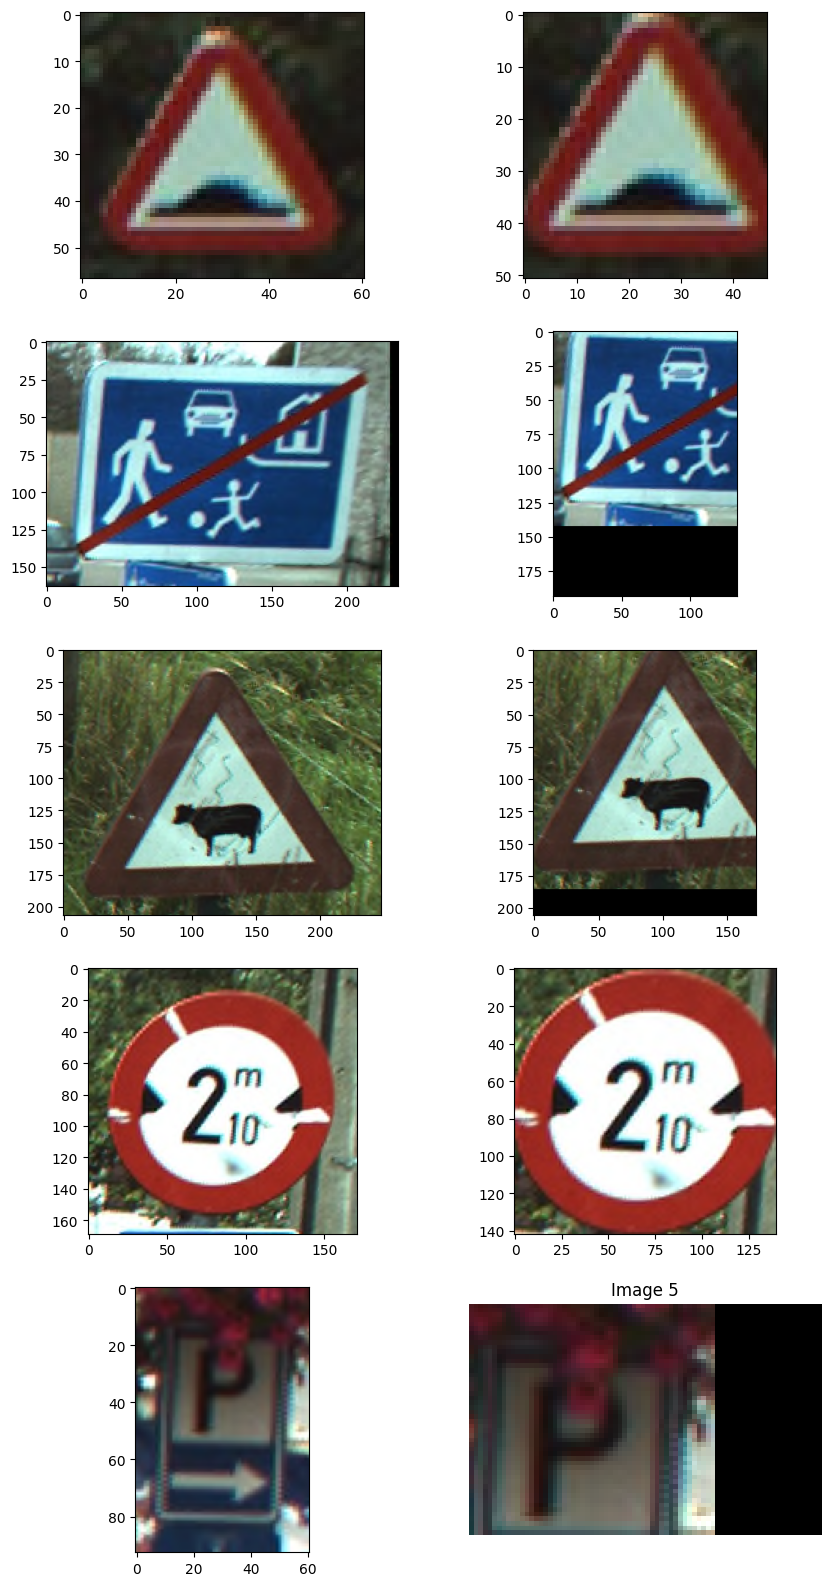

In [111]:
showExamples(df_test)

In [112]:
df_test = upSampleDataFrame(df_test,750)

Total number of images after Upsampling:  46672


Time taken to upsample images :  0.025425545374552407  min


In [113]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,46672.000000,46672.000000,46672.000000,46672.000000,46672.000000,46672.000000,46672.000000,46672.000000
mean,147.700013,136.392119,12.402447,11.484895,134.792295,124.405597,30.505528,47.650369
std,72.786024,76.040365,5.994741,6.274634,66.795623,69.825906,17.862947,92.608738
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.000000
25%,93.000000,74.000000,8.000000,6.000000,84.000000,67.000000,15.000000,0.000000
50%,134.000000,118.000000,11.000000,10.000000,123.000000,108.000000,31.000000,0.000000
75%,193.000000,171.000000,16.000000,14.000000,177.000000,156.000000,46.000000,24.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,352.000000


In [114]:
# Test Images Prediction
y_test,y_pred = PredictTest(model,df_test)

1459/1459 [==============================] - 119s 81ms/step


In [115]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  28.925265683921836

Confusion Matrix:
 [[  0 255   0 ...   0   0   0]
 [  1 435 225 ...   0   0   1]
 [  0   1   0 ...   0   0   0]
 ...
 [  1   0   0 ...   1   0   2]
 [  0   0   0 ...   0 736  12]
 [  0   0   0 ...   0   1 329]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.00,0.00,0.00,750
1,1,0.55,0.58,0.56,750
2,2,0.00,0.00,0.00,750
3,3,0.45,0.65,0.53,750
4,4,0.00,0.00,0.00,750
5,5,0.47,0.33,0.39,750
6,6,0.94,0.65,0.77,750
7,7,0.16,0.83,0.26,750
8,8,0.34,0.63,0.44,750
9,9,0.02,0.00,0.00,750


Original Value :  64.0
1/1 [==============================] - 0s 29ms/step
Predicted Value :  48


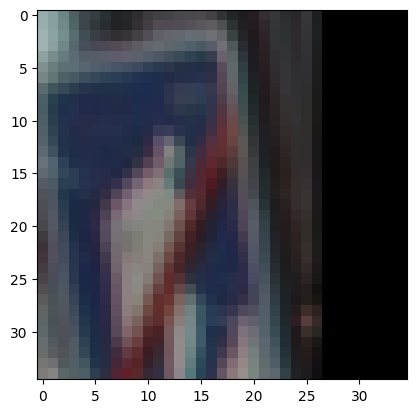

In [116]:
# Testing one Random Image from test data 
test_length = len(df_test)
select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row.iloc[0])
img = img.crop((row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[6]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)

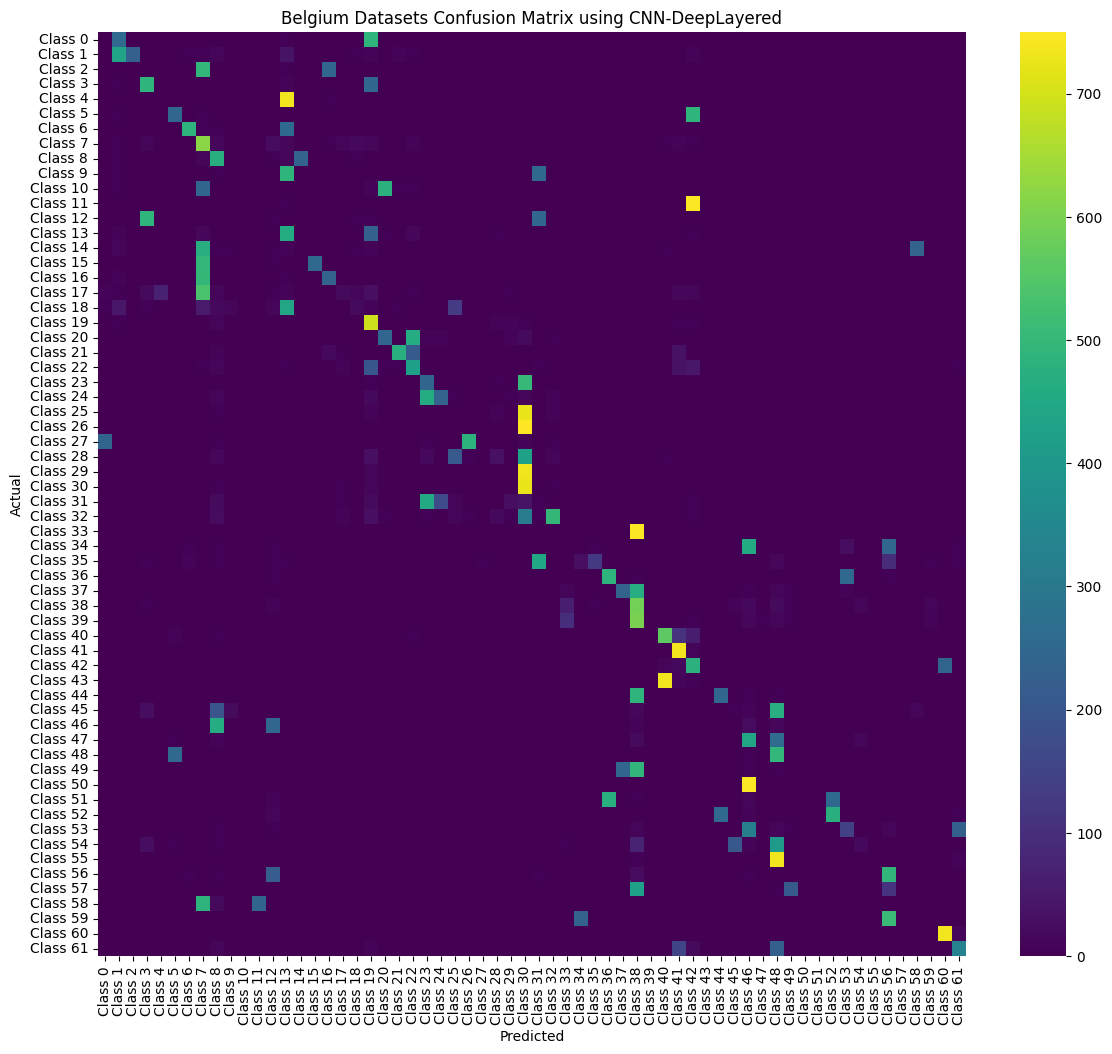

In [117]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Belgium Datasets Confusion Matrix using CNN-DeepLayered')
plt.show()